In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:

data = pd.read_csv('../data/modified_full_variants_long_table.csv')

filtered_data = data[
    (data['FILTER'] == 'PASS') & 
    (data['REF'].isin(['A', 'T', 'C', 'G'])) &
    (data['ALT'].isin(['A', 'T', 'C', 'G']))
]

main_genes = ['orf1ab', 'S', 'E']
filtered_data['Gene Category'] = filtered_data['GENE'].apply(lambda x: x if x in main_genes else 'Accessory genes')

gene_categories = {
    'orf1ab': filtered_data[filtered_data['GENE'] == 'orf1ab'],
    'S': filtered_data[filtered_data['GENE'] == 'S'],
    'E': filtered_data[filtered_data['GENE'] == 'E'],
    'Accessory genes': filtered_data[filtered_data['Gene Category'] == 'Accessory genes']
}

# <--- set plots params here ---> 
min_af = 0  
max_af = 0.20  
n_bins = 50  
bin_edges = np.linspace(min_af, max_af, n_bins + 1)

/var/folders/jw/x3fn2st54v7f8_8ll783l57c0000gn/T/ipykernel_10447/3648548971.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Gene Category'] = filtered_data['GENE'].apply(lambda x: x if x in main_genes else 'Accessory genes')


### Plots

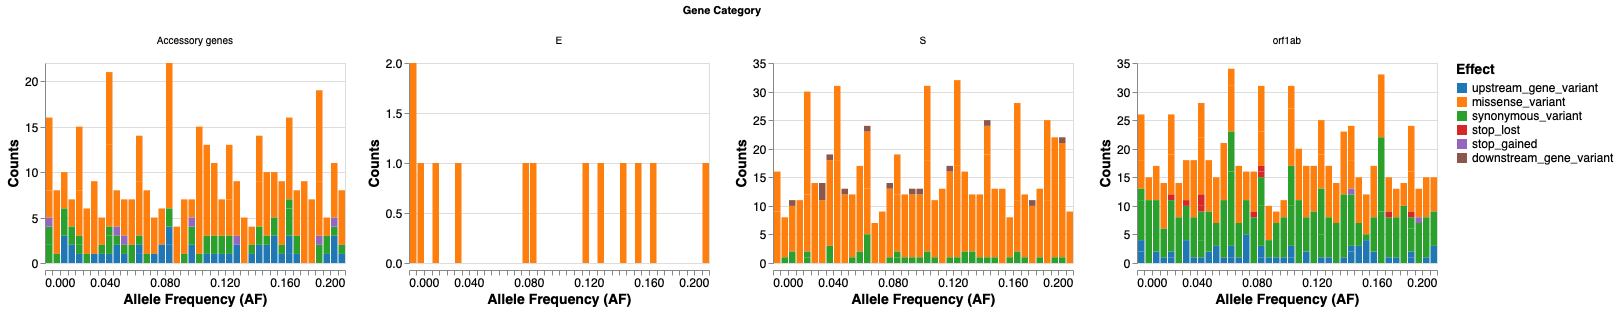

In [3]:
#  make altair plot AF freq 

alt_data = pd.DataFrame()
for gene, gene_data in gene_categories.items():
    effects = gene_data['EFFECT'].unique()
    for effect in effects:
        effect_data = gene_data[gene_data['EFFECT'] == effect]['AF']
        hist, edges = np.histogram(effect_data, bins=bin_edges)
        df = pd.DataFrame({
            'Counts': hist,
            'Allele Frequency': edges[:-1],
            'Gene': gene,
            'Effect': effect
        })
        alt_data = pd.concat([alt_data, df], ignore_index=True)

# set color scheme
color_scheme = alt.Scale(domain=list(alt_data['Effect'].unique()), scheme='category10')

# make plot
plot = alt.Chart(alt_data).mark_bar().encode(
    alt.X('Allele Frequency:Q', bin=alt.Bin(maxbins=n_bins), title='Allele Frequency (AF)'),
    alt.Y('Counts:Q', title='Counts'),
    alt.Color('Effect:N', scale=color_scheme, legend=alt.Legend(title="Effect"))
).properties(
    width=300,
    height=200
).facet(
    column=alt.Column('Gene:N', title='Gene Category')
).resolve_scale(
    y='independent'
).configure_title(
    fontSize=20,
    font='Arial',
    anchor='start',
    color='black'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
)


plot.display()


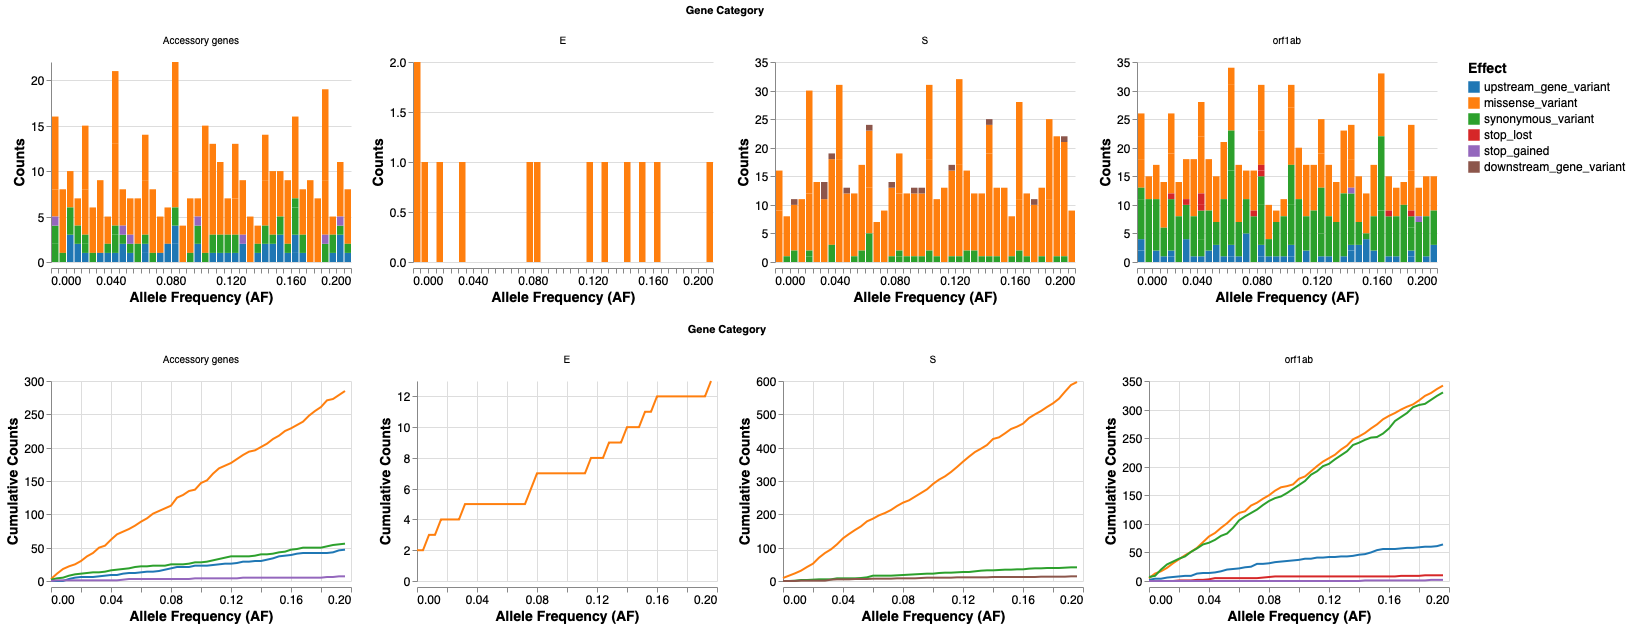

In [4]:
## <--- make combined plots ---> 

min_af = 0  
max_af = 0.2  
n_bins = 50  
bin_edges = np.linspace(min_af, max_af, n_bins + 1)

alt_data = pd.DataFrame()
for gene, gene_data in gene_categories.items():
    effects = gene_data['EFFECT'].unique()
    for effect in effects:
        effect_data = gene_data[gene_data['EFFECT'] == effect]['AF']
        hist, edges = np.histogram(effect_data, bins=bin_edges)
        cumsum = np.cumsum(hist)
        df = pd.DataFrame({
            'Counts': hist,
            'Cumulative Counts': cumsum,
            'Allele Frequency': edges[:-1],
            'Gene': gene,
            'Effect': effect
        })
        alt_data = pd.concat([alt_data, df], ignore_index=True)

color_scheme = alt.Scale(domain=list(alt_data['Effect'].unique()), scheme='category10')

histogram = alt.Chart(alt_data).mark_bar().encode(
    alt.X('Allele Frequency:Q', bin=alt.Bin(maxbins=n_bins), title='Allele Frequency (AF)'),
    alt.Y('Counts:Q', title='Counts'),
    alt.Color('Effect:N', scale=color_scheme, legend=alt.Legend(title="Effect"))
).properties(
    width=300,
    height=200
).facet(
    column=alt.Column('Gene:N', title='Gene Category')
).resolve_scale(
    y='independent'
)

cumulative_line = alt.Chart(alt_data).mark_line().encode(
    alt.X('Allele Frequency:Q', title='Allele Frequency (AF)'),
    alt.Y('Cumulative Counts:Q', title='Cumulative Counts'),
    alt.Color('Effect:N', scale=color_scheme, legend=alt.Legend(title="Effect"))
).properties(
    width=300,
    height=200
).facet(
    column=alt.Column('Gene:N', title='Gene Category')
).resolve_scale(
    y='independent'
)

combined_chart = alt.vconcat(histogram, cumulative_line).configure_title(
    fontSize=20,
    font='Arial',
    anchor='start',
    color='black'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
).configure_view(
    strokeWidth=0
)

combined_chart.display()


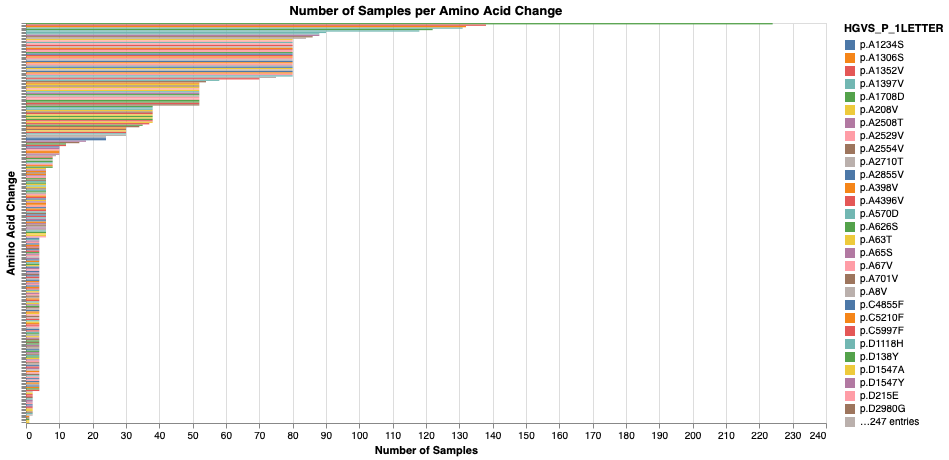

In [5]:
data = pd.read_csv('../data/modified_full_variants_long_table.csv')

filtered_data = data[
    (data['FILTER'] == 'PASS') & 
    (data['REF'].isin(['A', 'T', 'C', 'G'])) &
    (data['ALT'].isin(['A', 'T', 'C', 'G'])) &
    (data['EFFECT'] == 'missense_variant') # only looks at missense mutations 
]


amino_acid_counts = filtered_data.groupby('HGVS_P_1LETTER')['SAMPLE'].nunique().reset_index()
amino_acid_counts.columns = ['HGVS_P_1LETTER', 'Unique_Sample_Count']

chart = alt.Chart(amino_acid_counts).mark_bar().encode(
    x=alt.X('Unique_Sample_Count:Q', title='Number of Samples'),
    y=alt.Y('HGVS_P_1LETTER:N', title='Amino Acid Change', sort='-x', axis=alt.Axis(labels=False)), # mod sort -x / x to reverse top/bottom
    color='HGVS_P_1LETTER:N',
    tooltip=['HGVS_P_1LETTER', 'Unique_Sample_Count']
).properties(
    title='Number of Samples per Amino Acid Change',
    width=800,
    height=400
)#.interactive()

chart


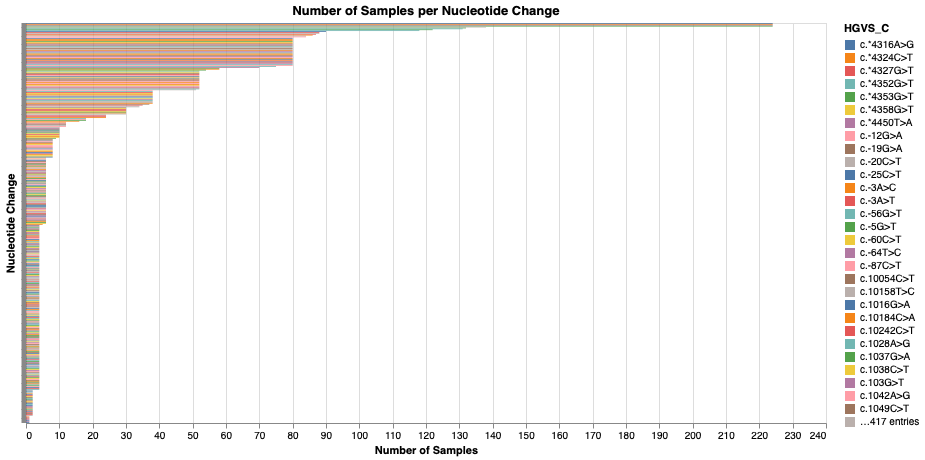

In [6]:

data = pd.read_csv('../data/modified_full_variants_long_table.csv')

filtered_data = data[
    (data['FILTER'] == 'PASS') & 
    (data['REF'].isin(['A', 'T', 'C', 'G'])) &
    (data['ALT'].isin(['A', 'T', 'C', 'G']))
]



nuc_counts = filtered_data.groupby('HGVS_C')['SAMPLE'].nunique().reset_index()
nuc_counts.columns = ['HGVS_C', 'Unique_Sample_Count']

chart = alt.Chart(nuc_counts).mark_bar().encode(
    x=alt.X('Unique_Sample_Count:Q', title='Number of Samples'),
    y=alt.Y('HGVS_C:N', title='Nucleotide Change', sort='-x', axis=alt.Axis(labels=False)), # mod sort -x / x to reverse top/bottom
    color='HGVS_C:N',
    tooltip=['HGVS_C', 'Unique_Sample_Count']
).properties(
    title='Number of Samples per Nucleotide Change',
    width=800,
    height=400
)#.interactive()

chart


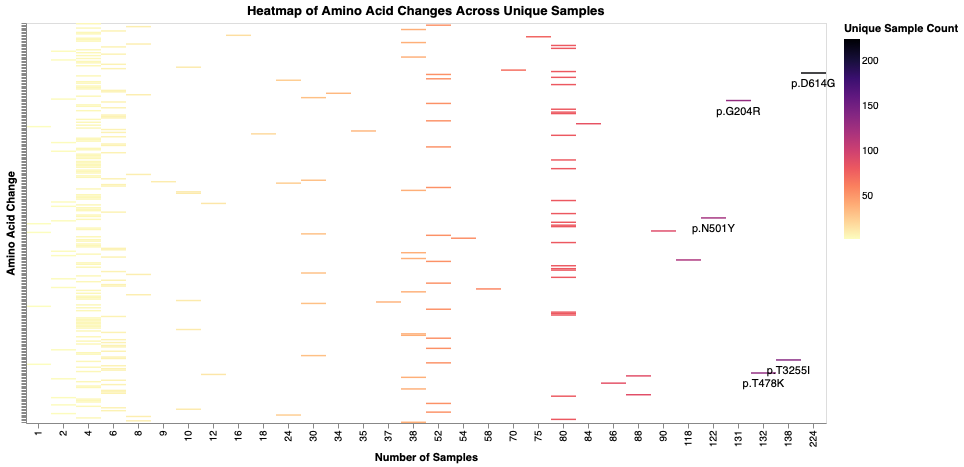

In [7]:

data = pd.read_csv('../data/modified_full_variants_long_table.csv')


filtered_data = data[
    (data['FILTER'] == 'PASS') & 
    (data['REF'].isin(['A', 'T', 'C', 'G'])) &
    (data['ALT'].isin(['A', 'T', 'C', 'G'])) &
    (data['EFFECT'] == 'missense_variant') # only looks at missense mutations 
]


amino_acid_counts = filtered_data.groupby('HGVS_P_1LETTER')['SAMPLE'].nunique().reset_index()
amino_acid_counts.columns = ['HGVS_P_1LETTER', 'Unique_Sample_Count']


top_10_amino_acids = amino_acid_counts.nlargest(5, 'Unique_Sample_Count')


heatmap = alt.Chart(amino_acid_counts).mark_rect().encode(
    x=alt.X('Unique_Sample_Count:O', title='Number of Samples'),
    y=alt.Y('HGVS_P_1LETTER:N', title='Amino Acid Change', axis=alt.Axis(labels=False)),
    color=alt.Color('Unique_Sample_Count:Q', title='Unique Sample Count', scale=alt.Scale(scheme='magma', reverse=True)),
    tooltip=['HGVS_P_1LETTER', 'Unique_Sample_Count']
).properties(
    title='Heatmap of Amino Acid Changes Across Unique Samples',
    width=800,
    height=400
).interactive()


text = alt.Chart(top_10_amino_acids).mark_text(
    align='center',
    baseline='top',
    dy=5  # places txt below 
).encode(
    x=alt.X('Unique_Sample_Count:O', title='Number of Samples'),
    y=alt.Y('HGVS_P_1LETTER:N', title='Amino Acid Change'),
    text=alt.Text('HGVS_P_1LETTER:N'),
    color=alt.value('black')  
)


combined_chart = heatmap + text

combined_chart

## NOTE: To read plot cursor over p.D614D in upper rigiht corner shows this mutation is present in 224 uniqe samples in the dataset. 


### Stats ...

In [8]:
data = pd.read_csv('../data/combined_variants_long_table.csv')

filtered_data = data[
    (data['FILTER'] == 'PASS') & 
    (data['REF'].isin(['A', 'T', 'C', 'G'])) &
    (data['ALT'].isin(['A', 'T', 'C', 'G']))
]

In [9]:
effect_means = filtered_data.groupby('EFFECT')['AF'].mean().reset_index()
effect_means = effect_means.sort_values(by='AF', ascending=False)

gene_means = filtered_data.groupby('GENE')['AF'].mean().reset_index()
gene_means = gene_means.sort_values(by='AF', ascending=False)



In [10]:
effect_means

,EFFECT,AF
0,missense_variant,0.033056
1,stop_gained,0.030000
2,synonymous_variant,0.016000


In [11]:
gene_means

,GENE,AF
5,orf1ab,0.037586
2,ORF7a,0.030000
0,N,0.018000
1,ORF6,0.015000
4,S,0.013333
3,ORF8,0.010000


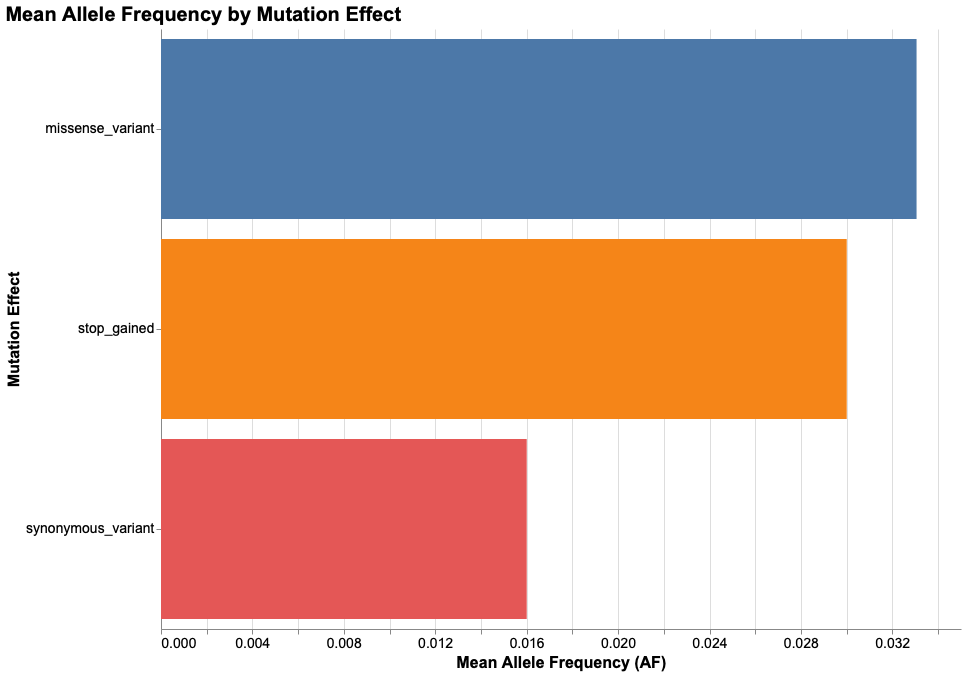

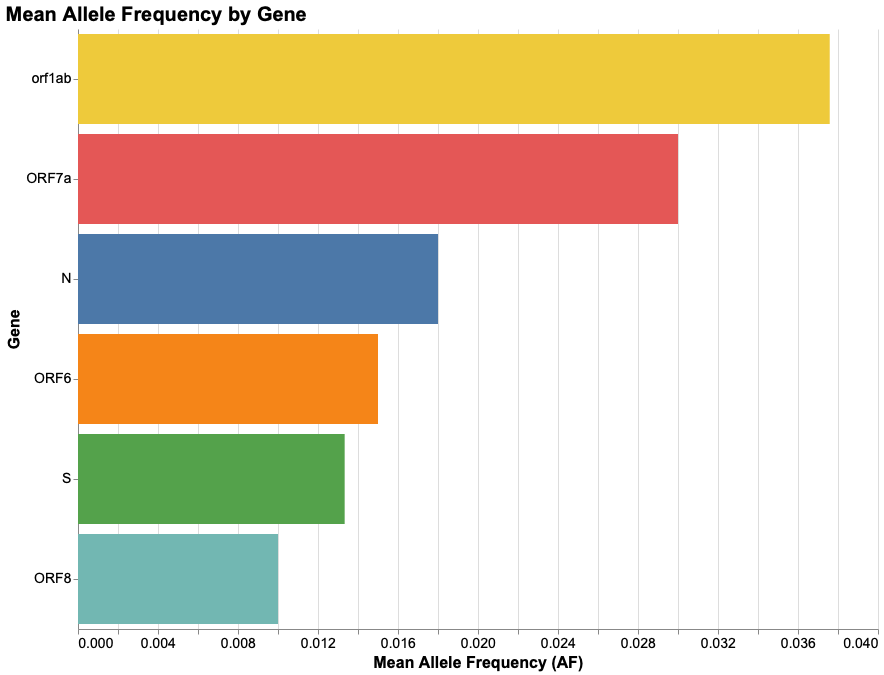

In [12]:

data = pd.read_csv("../data/combined_variants_long_table.csv")


filtered_data = data[
    (data['FILTER'] == 'PASS') & 
    (data['REF'].isin(['A', 'T', 'C', 'G'])) &
    (data['ALT'].isin(['A', 'T', 'C', 'G']))
]


effect_means = filtered_data.groupby('EFFECT')['AF'].mean().reset_index()
effect_means = effect_means.sort_values(by='AF', ascending=False)

gene_means = filtered_data.groupby('GENE')['AF'].mean().reset_index()
gene_means = gene_means.sort_values(by='AF', ascending=False)

# make plot - mean AF by mutation effect 
effect_chart = alt.Chart(effect_means).mark_bar().encode(
    x=alt.X('AF:Q', title='Mean Allele Frequency (AF)', axis=alt.Axis(grid=True)),
    y=alt.Y('EFFECT:N', sort='-x', title='Mutation Effect'),
    color=alt.Color('EFFECT:N', legend=None)
).properties(
    title='Mean Allele Frequency by Mutation Effect',
    width=800,
    height=600
).configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelFont='Arial',
    titleFont='Arial'
).configure_title(
    fontSize=20,
    font='Arial',
    anchor='start',
    fontWeight='bold'
).configure_view(
    strokeOpacity=0
)

# make plot - mean AF by gene 
gene_chart = alt.Chart(gene_means).mark_bar().encode(
    x=alt.X('AF:Q', title='Mean Allele Frequency (AF)', axis=alt.Axis(grid=True)),
    y=alt.Y('GENE:N', sort='-x', title='Gene'),
    color=alt.Color('GENE:N', legend=None)
).properties(
    title='Mean Allele Frequency by Gene',
    width=800,
    height=600
).configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelFont='Arial',
    titleFont='Arial'
).configure_title(
    fontSize=20,
    font='Arial',
    anchor='start',
    fontWeight='bold'
).configure_view(
    strokeOpacity=0
)



# Display the charts
effect_chart.display()
gene_chart.display()


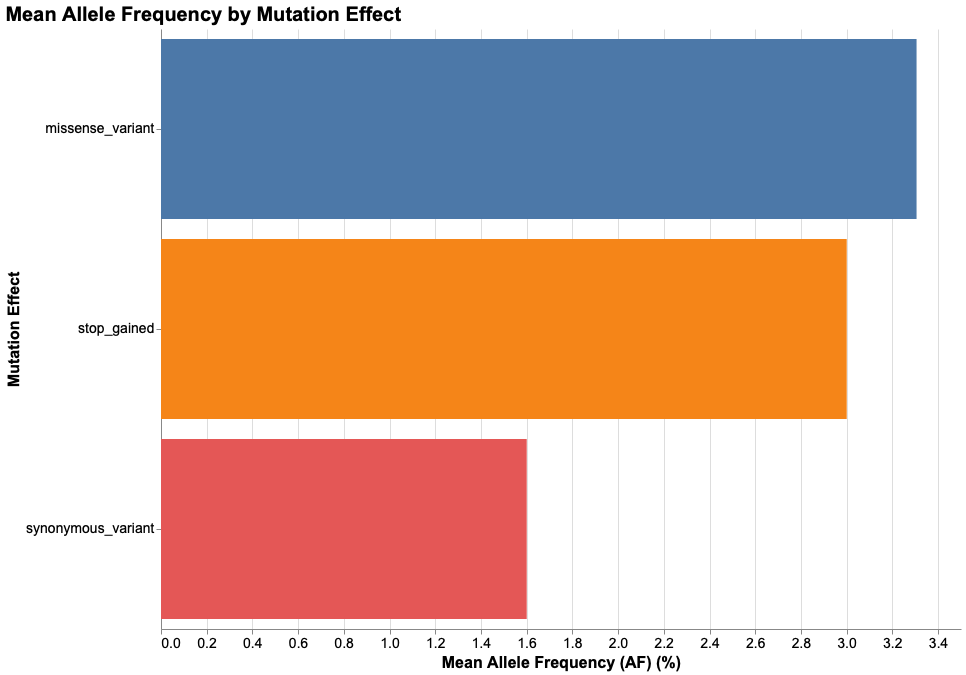

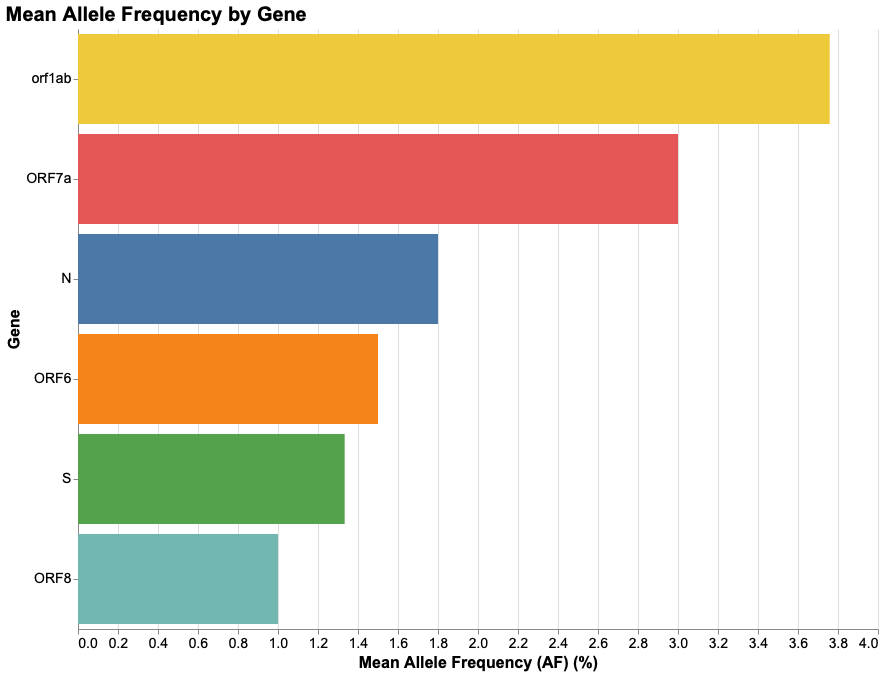

In [13]:

# make plot - convert AF to percent 
effect_means['AF'] = effect_means['AF'] * 100
gene_means['AF'] = gene_means['AF'] * 100

# make plot - mean AF by mutation effect 
effect_chart = alt.Chart(effect_means).mark_bar().encode(
    x=alt.X('AF:Q', title='Mean Allele Frequency (AF) (%)', axis=alt.Axis(grid=True)),
    y=alt.Y('EFFECT:N', sort='-x', title='Mutation Effect'),
    color=alt.Color('EFFECT:N', legend=None)
).properties(
    title='Mean Allele Frequency by Mutation Effect',
    width=800,
    height=600
).configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelFont='Arial',
    titleFont='Arial'
).configure_title(
    fontSize=20,
    font='Arial',
    anchor='start',
    fontWeight='bold'
).configure_view(
    strokeOpacity=0
)

# make plot - mean AF by gene 
gene_chart = alt.Chart(gene_means).mark_bar().encode(
    x=alt.X('AF:Q', title='Mean Allele Frequency (AF) (%)', axis=alt.Axis(grid=True)),
    y=alt.Y('GENE:N', sort='-x', title='Gene'),
    color=alt.Color('GENE:N', legend=None)
).properties(
    title='Mean Allele Frequency by Gene',
    width=800,
    height=600
).configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelFont='Arial',
    titleFont='Arial'
).configure_title(
    fontSize=20,
    font='Arial',
    anchor='start',
    fontWeight='bold'
).configure_view(
    strokeOpacity=0
)


effect_chart.display()
gene_chart.display()


In [15]:
#